## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [1]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

In [2]:
import os
os.chdir("/home/brash/Phys421/WWO")
df = pd.read_csv('regina.csv')
dfnew = pd.read_csv('regina_2018.csv')

In [3]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.
#
# The factor 8*N takes into account that the data in our dataframe
# is reported once every three hours (or 8 times per day)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*8*N + [df[feature][i-8*N] for i in range(8*N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [4]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [5]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)
            derive_nth_day_feature(dfnew, feature, N)

In [6]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,6.320548,-1.304110,0.096986,9.662740,2.778082,45.084932,-2.838014,-0.770548,2.878082,-0.827740,...,9.672928,15.394574,15.407369,15.426796,208.945398,208.695592,208.353591,0.246291,0.246970,0.247652
std,15.216829,13.729361,0.388413,4.160689,1.682609,31.265919,12.333195,17.486786,14.668713,17.401909,...,4.176386,6.757152,6.760687,6.759334,94.242035,94.249179,94.153133,1.124402,1.125876,1.127356
min,-28.000000,-36.000000,0.000000,3.000000,1.000000,0.000000,-40.000000,-46.000000,-36.000000,-46.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-6.000000,-12.000000,0.000000,5.900000,1.000000,17.000000,-10.000000,-14.000000,-8.000000,-14.000000,...,5.900000,10.000000,10.000000,10.000000,130.000000,129.000000,129.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,9.200000,2.000000,44.000000,-2.000000,1.000000,4.000000,1.000000,...,9.300000,14.000000,14.000000,14.000000,217.000000,216.500000,216.000000,0.000000,0.000000,0.000000
75%,20.000000,11.000000,0.000000,13.500000,4.000000,72.000000,7.000000,14.000000,15.000000,14.000000,...,13.500000,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000
max,32.000000,21.000000,3.400000,16.700000,7.000000,100.000000,19.000000,33.000000,33.000000,31.000000,...,16.700000,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000


In [7]:
dfnew.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,7.824658,-0.356164,0.069041,10.023836,2.969863,46.734247,-2.088014,0.217808,3.687329,0.176712,...,10.060773,15.223214,15.208678,15.222030,206.478365,206.871212,206.910221,0.054808,0.054855,0.055007
std,14.710897,13.226122,0.403412,4.281772,1.898174,31.277963,10.512825,17.124911,14.409367,17.075983,...,4.275437,7.548558,7.552858,7.556585,94.994980,94.821063,94.883997,0.474435,0.475059,0.475706
min,-23.000000,-29.000000,0.000000,3.000000,1.000000,0.000000,-30.000000,-38.000000,-29.000000,-38.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.000000,-11.000000,0.000000,6.700000,1.000000,19.000000,-9.000000,-13.000000,-7.000000,-13.000000,...,6.700000,10.000000,10.000000,10.000000,136.000000,136.000000,136.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000,10.100000,2.000000,46.000000,-2.000000,-1.000000,2.000000,-1.000000,...,10.100000,14.000000,14.000000,14.000000,209.000000,209.000000,209.000000,0.000000,0.000000,0.000000
75%,22.000000,12.000000,0.000000,14.500000,5.000000,74.000000,7.000000,16.000000,16.000000,16.000000,...,14.500000,20.000000,20.000000,20.000000,293.000000,293.000000,294.000000,0.000000,0.000000,0.000000
max,41.000000,23.000000,4.300000,16.700000,8.000000,100.000000,21.000000,41.000000,41.000000,41.000000,...,16.700000,42.000000,42.000000,42.000000,360.000000,360.000000,360.000000,13.500000,13.500000,13.500000


In [8]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df = df[to_keep]
dfnew = dfnew[to_keep]


['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


In [18]:
df.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date,date_delta
24,2019-01-04 00:00:00,1,-10,-8,-5.0,-11.0,-28.0,-4.0,-8.0,-30.0,...,22.0,10.0,254.0,291.0,203.0,0.0,0.0,0.0,2019-01-04 00:00:00,3.000
25,2019-01-04 03:00:00,1,-10,-9,-5.0,-8.0,-28.0,-7.0,-9.0,-30.0,...,21.0,12.0,256.0,301.0,184.0,0.0,0.0,0.0,2019-01-04 03:00:00,3.125
26,2019-01-04 06:00:00,1,-10,-10,-6.0,-11.0,-27.0,-7.0,-12.0,-29.0,...,16.0,14.0,259.0,298.0,172.0,0.0,0.0,0.0,2019-01-04 06:00:00,3.250
27,2019-01-04 09:00:00,1,-10,-9,-5.0,-10.0,-24.0,-6.0,-11.0,-27.0,...,14.0,16.0,260.0,277.0,177.0,0.0,0.0,0.0,2019-01-04 09:00:00,3.375
28,2019-01-04 12:00:00,1,-10,-2,-2.0,-5.0,-18.0,-3.0,-7.0,-22.0,...,15.0,18.0,261.0,259.0,192.0,0.0,0.0,0.0,2019-01-04 12:00:00,3.500


In [9]:
# the last task is to convert the date_time column from an object into a floating point number
# there are a number of ways that we could do this

df['date'] = pd.to_datetime(df['date_time'])    
df['date_delta'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')

dfnew['date'] = pd.to_datetime(dfnew['date_time'])    
dfnew['date_delta'] = (dfnew['date'] - dfnew['date'].min())  / np.timedelta64(1,'D')



In [19]:
dfnew.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date,date_delta
24,2018-01-04 00:00:00,-10,-12,-12,-18.0,-18.0,-26.0,-19.0,-21.0,-26.0,...,23.0,4.0,329.0,235.0,241.0,0.0,0.0,0.0,2018-01-04 00:00:00,3.000
25,2018-01-04 03:00:00,-10,-12,-12,-17.0,-14.0,-25.0,-18.0,-19.0,-26.0,...,23.0,6.0,202.0,251.0,205.0,0.0,0.0,0.0,2018-01-04 03:00:00,3.125
26,2018-01-04 06:00:00,-10,-12,-12,-16.0,-10.0,-25.0,-17.0,-14.0,-27.0,...,28.0,8.0,138.0,290.0,191.0,0.0,0.0,0.0,2018-01-04 06:00:00,3.250
27,2018-01-04 09:00:00,-10,-12,-11,-14.0,-10.0,-25.0,-15.0,-12.0,-27.0,...,23.0,10.0,140.0,301.0,199.0,0.0,0.0,0.0,2018-01-04 09:00:00,3.375
28,2018-01-04 12:00:00,-10,-12,-10,-11.0,-8.0,-22.0,-11.0,-10.0,-26.0,...,29.0,14.0,157.0,322.0,212.0,0.0,0.0,0.0,2018-01-04 12:00:00,3.500


In [10]:
# Now, let's get rid of the rows that do not have complete data!

df = df.dropna()
dfnew = dfnew.dropna()

## We are now ready to do a linear regression fit to the data!!

In [11]:
# for our model, we will only include variables where the abs(r) > 0.4 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_1', 
              'mintempC_1',   'tempC_2',   'DewPointC_2',
              'maxtempC_2', 'mintempC_2', 'tempC_3',
              'DewPointC_3',  'mintempC_3',  'maxtempC_3',
              'pressure_1',  'pressure_2',  'pressure_3',
              'humidity_1',   'humidity_2', 'humidity_3',
              'sunHour_1', 'sunHour_2', 'sunHour_3']
df2 = df[['date_delta']+['tempC'] + predictors]
df2new = dfnew[['date_delta']+['tempC'] + predictors]

In [12]:
# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors+['date_delta']]
y = df2['tempC']
Xnew = df2new[predictors+['date_delta']]
ynew = df2new['tempC']

In [13]:
# Looking at the p-values of this fit, we see that MANY of them are well above the
# threshold alpha=0.05 that we require for significance.  Thus, we should remove these!
#
# If we do not, we are guilty of OVERFITTING the data!!!!!!

X = X.drop('tempC_1', axis=1)
X = X.drop('mintempC_2', axis=1)
X = X.drop('mintempC_1', axis=1)
X = X.drop('DewPointC_3', axis=1)
X = X.drop('DewPointC_2', axis=1)
X = X.drop('maxtempC_3', axis=1)
X = X.drop('humidity_2', axis=1)
X = X.drop('pressure_2', axis=1)
X = X.drop('pressure_3', axis=1)

Xnew = Xnew.drop('tempC_1', axis=1)
Xnew = Xnew.drop('mintempC_2', axis=1)
Xnew = Xnew.drop('mintempC_1', axis=1)
Xnew = Xnew.drop('DewPointC_3', axis=1)
Xnew = Xnew.drop('DewPointC_2', axis=1)
Xnew = Xnew.drop('maxtempC_3', axis=1)
Xnew = Xnew.drop('humidity_2', axis=1)
Xnew = Xnew.drop('pressure_2', axis=1)
Xnew = Xnew.drop('pressure_3', axis=1)

## OK, so I lied ... now we are REALLY read to do the linear regression fit!  We had to prepare the data a bit more, didn't we?

In [14]:
#from sklearn.model_selection import train_test_split
#
# Note:  In a lot of situations, we have a single dataframe, and
# we want to split that dataframe into a test set and a training set.
# We can do that with something like the following:
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
# But, in this particular case, we want to use 2019 as the training
# set, and then use 2018 as the test set.
 
# Important point!!! We do not have to add in a constant column,
# because sklearn will do that for us!!!

X_train = X
X_test = Xnew
y_train = y
y_test = ynew

In [20]:
X_train.head()

,DewPointC_1,maxtempC_1,tempC_2,maxtempC_2,tempC_3,mintempC_3,pressure_1,humidity_1,humidity_3,sunHour_1,sunHour_2,sunHour_3,date_delta
24,-4.0,0.0,-11.0,-1.0,-28.0,-26.0,1004.0,83.0,73.0,8.5,5.0,5.0,3.000
25,-7.0,0.0,-8.0,-1.0,-28.0,-26.0,1005.0,82.0,76.0,8.5,5.0,5.0,3.125
26,-7.0,0.0,-11.0,-1.0,-27.0,-26.0,1005.0,83.0,75.0,8.5,5.0,5.0,3.250
27,-6.0,0.0,-10.0,-1.0,-24.0,-26.0,1005.0,83.0,73.0,8.5,5.0,5.0,3.375
28,-3.0,0.0,-5.0,-1.0,-18.0,-26.0,1006.0,82.0,69.0,8.5,5.0,5.0,3.500


In [21]:
X_test.head()

,DewPointC_1,maxtempC_1,tempC_2,maxtempC_2,tempC_3,mintempC_3,pressure_1,humidity_1,humidity_3,sunHour_1,sunHour_2,sunHour_3,date_delta
24,-19.0,-9.0,-18.0,-8.0,-26.0,-26.0,1033.0,93.0,94.0,5.0,5.0,8.5,3.000
25,-18.0,-9.0,-14.0,-8.0,-25.0,-26.0,1032.0,90.0,92.0,5.0,5.0,8.5,3.125
26,-17.0,-9.0,-10.0,-8.0,-25.0,-26.0,1031.0,92.0,87.0,5.0,5.0,8.5,3.250
27,-15.0,-9.0,-10.0,-8.0,-25.0,-26.0,1029.0,94.0,81.0,5.0,5.0,8.5,3.375
28,-11.0,-9.0,-8.0,-8.0,-22.0,-26.0,1027.0,96.0,68.0,5.0,5.0,8.5,3.500


In [22]:
y_train.head()

24    -8
25    -9
26   -10
27    -9
28    -2
Name: tempC, dtype: int64

In [23]:
y_test.head()

24   -12
25   -12
26   -12
27   -11
28   -10
Name: tempC, dtype: int64

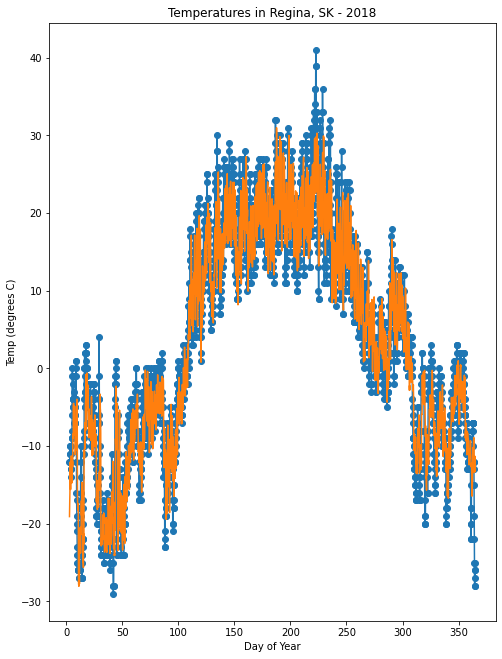

The Explained Variance: 0.91
The Mean Absolute Error: 3.10 degrees celsius
The Median Absolute Error: 2.33 degrees celsius


In [15]:
from sklearn.linear_model import LinearRegression

# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set!!! Never use training data to test!!!!
prediction = regressor.predict(X_test)

x = X_test['date_delta']

df_final = pd.DataFrame({'x':x, 'yData':y_test, 'yFit': prediction, 'Residual': y_test-prediction})
df_final = df_final.sort_values(by=['x'])

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData'],'o-')
axs2.set_ylabel('Temp (degrees C)')
axs2.set_xlabel('Day of Year')
axs2.set_title('Temperatures in Regina, SK - 2018')
#axs2.set_xlim(180,200)
#axs2.set_ylim(0,30)
axs2.plot(df_final['x'],df_final['yFit'])

plt.show()

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))


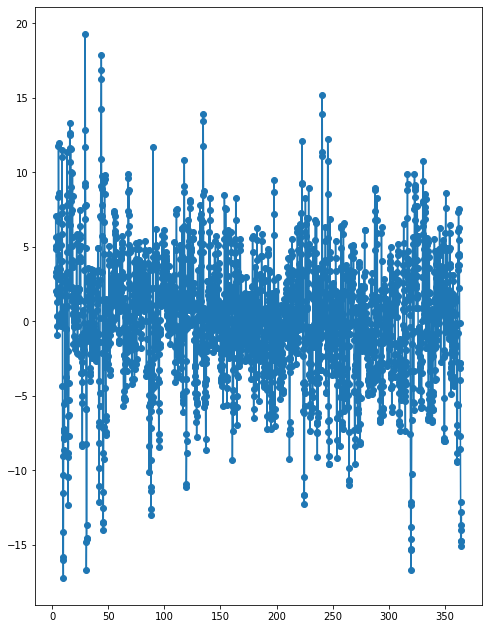

In [24]:
fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData']-df_final['yFit'],'o-')

(array([  1.,   2.,   0.,   2.,   0.,   3.,   3.,   3.,   3.,   3.,   2.,
          1.,   3.,   6.,   0.,   5.,   4.,   3.,   3.,   2.,   5.,   6.,
          7.,   5.,  10.,  13.,  17.,  17.,  23.,  18.,  25.,  33.,  31.,
         36.,  38.,  48.,  48.,  57.,  61.,  67.,  71.,  78.,  97., 115.,
        126., 126., 120., 111., 118., 143., 117., 113., 110.,  90.,  83.,
         94.,  75.,  58.,  48.,  51.,  50.,  46.,  39.,  27.,  21.,  19.,
         19.,  19.,  12.,  10.,  14.,  11.,   9.,   4.,   6.,   0.,   4.,
          3.,   5.,   5.,   2.,   2.,   1.,   2.,   0.,   2.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.]), array([-17.19037978, -16.8257276 , -16.46107542, -16.09642324,
        -15.73177106, -15.36711888, -15.00246669, -14.63781451,
        -14.27316233, -13.90851015, -13.54385797, -13.17920579,
        -12.81455361, -12.44990143, -12.08524924, -11.72059706,
        -11.35594488, -10.9912927 , -10.62664052, -10.26198834,

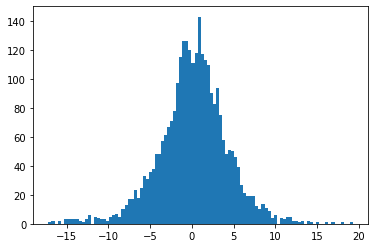

In [25]:
plt.hist(df_final['yData']-df_final['yFit'],bins=100)

0.1632563099283608 4.1577340848045585


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Legend does not support 'Fit' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Legend does not support 'Data' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


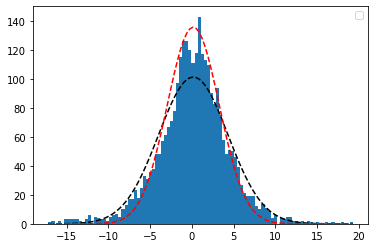

In [43]:
# best fit of data
data = df_final['yData']-df_final['yFit']
(mu, sigma) = stats.norm.fit(data)
print (mu,sigma)

# Empirical average and variance are computed
nbins = 100
avg = mu
var = sigma**2
N = len(df_final)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(data),np.max(data),nbins)
bin_size = (np.max(data) - np.min(data))/nbins
pdf_y = N*bin_size/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

var_mean = (mean_absolute_error(y_test, prediction)**2)
pdf_y2 = N*bin_size/np.sqrt(2*np.pi*var_mean)*np.exp(-0.5*(pdf_x-avg)**2/var_mean)

plt.hist(data,bins=100)
plt.plot(pdf_x,pdf_y,'k--')
plt.plot(pdf_x,pdf_y2,'r--')
plt.legend(("Fit","Data"),"best")
plt.show()